# Parameters

In [1]:
source_folder = 'data'
destination_folder = 'models'

# Libraries

In [2]:
!pip install transformers

In [4]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn import metrics

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
# Model parameter
MAX_SEQ_LEN = 202
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False,
                   include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]


train_dev_df = pd.read_csv('data/train_dev.csv')
test_df = pd.read_csv('data/test.csv')

train_df, dev_df = train_test_split(train_dev_df, test_size=0.1, random_state=42, shuffle=True)
train_df.to_csv("data/train.csv", index=False)
dev_df.to_csv("data/dev.csv", index=False)

print(len(train_df), "train", len(dev_df), "dev", len(test_df), "test")

print(train_df.head())
print(dev_df.head())
print(test_df.head())

2671 train 297 dev 400 test
                                                   text  label
2415  T A T G G G T T T A A T T T G A A A T C C A T ...      0
402   G G G G G G T G A A T A T G G T T G G C C T G ...      1
2964  A G A G G G A C T T T G T C T T T A C C C A A ...      0
1187  C A C A A T G T A G A A G C A G A G A C A C A ...      1
2622  G G G A G G C A C C T C C C A C T A G G G G C ...      0
                                                   text  label
2397  T G G C T C T T T C T T A A A A T G T C T A T ...      0
1222  C C C G G C C T C C T G C C C C T T T G G G A ...      1
2402  C T C T G G C C A T A A C T T T T G C A G G A ...      0
332   T G C C C A G A G T C T T A G C T G T G C T T ...      1
1475  C T G C C C T C C T G G A G G A G A G A G C C ...      1
                                                text  label
0  A T G C T G C C A G A A G G A A A A G G G G T ...      1
1  G G C A T T T T T T A A C C T G T G T T T C A ...      1
2  G A A A C C A C A G A G C T G A C

/home/darg1/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [8]:
train, dev, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='dev.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

/home/darg1/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/darg1/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [9]:
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
dev_iter = BucketIterator(dev, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

/home/darg1/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/darg1/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Models

In [10]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [11]:
# Save and Load Functions

def save_checkpoint(save_path, model, dev_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'dev_loss': dev_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['dev_loss']


def save_metrics(save_path, train_loss_list, dev_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'dev_loss_list': dev_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['dev_loss_list'], state_dict['global_steps_list']

In [12]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          dev_loader = dev_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_dev_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    dev_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    dev_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (texts, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            texts = texts.type(torch.LongTensor)  
            texts = texts.to(device)
            output = model(texts, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # dev loop
                    for (texts, labels), _ in dev_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        texts = texts.type(torch.LongTensor)  
                        texts = texts.to(device)
                        output = model(texts, labels)
                        loss, _ = output
                        
                        dev_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_dev_loss = dev_running_loss / len(dev_loader)
                train_loss_list.append(average_train_loss)
                dev_loss_list.append(average_dev_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                dev_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Dev Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_dev_loss))
                
                # checkpoint
                if best_dev_loss > average_dev_loss:
                    best_dev_loss = average_dev_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_dev_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, dev_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, dev_loss_list, global_steps_list)
    print('Finished Training!')

In [13]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [83/835], Train Loss: 0.6613, Dev Loss: 0.5263
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [1/5], Step [166/835], Train Loss: 0.5474, Dev Loss: 0.5351
Epoch [2/5], Step [249/835], Train Loss: 0.5554, Dev Loss: 0.4583
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [2/5], Step [332/835], Train Loss: 0.5123, Dev Loss: 0.5059
Epoch [3/5], Step [415/835], Train Loss: 0.5468, Dev Loss: 0.4592
Epoch [3/5], Step [498/835], Train Loss: 0.5083, Dev Loss: 0.4857
Epoch [4/5], Step [581/835], Train Loss: 0.5536, Dev Loss: 0.4592
Epoch [4/5], Step [664/835], Train Loss: 0.4995, Dev Loss: 0.4544
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [5/5], Step [747/835], Train Loss: 0.5443, Dev Loss: 0.4514
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [5/5], Step [830/835], Train Loss: 0.4877, Dev Loss: 0.4491
Model saved to ==> models/model.pt
Model saved to ==>

Model loaded from <== models/metrics.pt


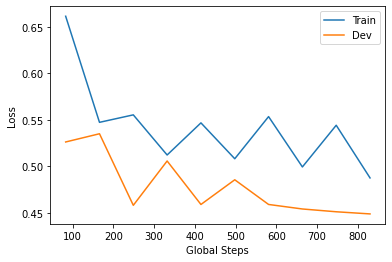

In [14]:
train_loss_list, dev_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, dev_loss_list, label='Dev')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [15]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (texts, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                texts = texts.type(torch.LongTensor)  
                texts = texts.to(device)
                output = model(texts, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['ENHANCER', 'NON-ENHANCER'])
    ax.yaxis.set_ticklabels(['ENHANCER', 'NON-ENHANCER'])

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print("AUC=", metrics.auc(fpr, tpr))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== models/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7697    0.6850    0.7249       200
           0     0.7162    0.7950    0.7536       200

    accuracy                         0.7400       400
   macro avg     0.7429    0.7400    0.7392       400
weighted avg     0.7429    0.7400    0.7392       400

AUC= 0.7400000000000001


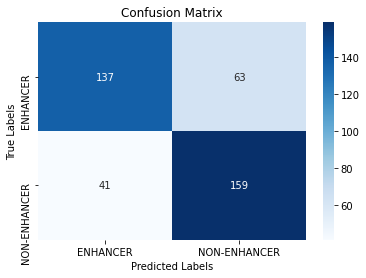

In [16]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)